<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/gan/basic_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128(pic) x 784 (28*28)
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1 x 28 x 28 = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

In [ ]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda' #gpu

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

100%|██████████| 9912422/9912422 [00:00<00:00, 257749150.63it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89333107.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 165852691.83it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15968590.75it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# declare models

#Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), #enter 64, exit 128
        genBlock(h_dim, h_dim*2), #128, 256
        genBlock(h_dim*2, h_dim*4), #256, 512
        genBlock(h_dim*4, h_dim*8), #512, 1024
        nn.Linear(h_dim*8, i_dim), #1024, 784 (28*28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), #784, 1024
        discBlock(h_dim*4, h_dim*2), #1024, 512
        discBlock(h_dim*2, h_dim), #512, 256
        nn.Linear(h_dim, 1) #256, 1
    )

  def forward(self,image):
    return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([3, 5, 5, 1, 4, 6, 7, 3, 3, 9])


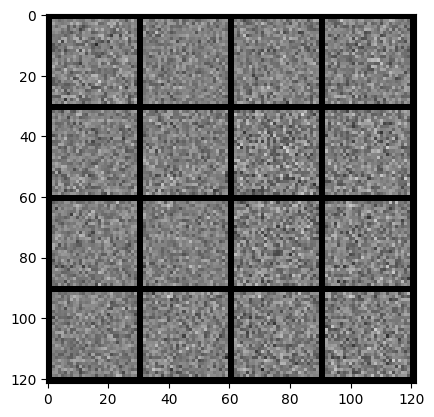

In [ ]:
x,y=next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculate the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss=loss_func(pred,targets)

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets=torch.ones_like(disc_real)
  disc_real_loss=loss_func(disc_real, disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss)/2

  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

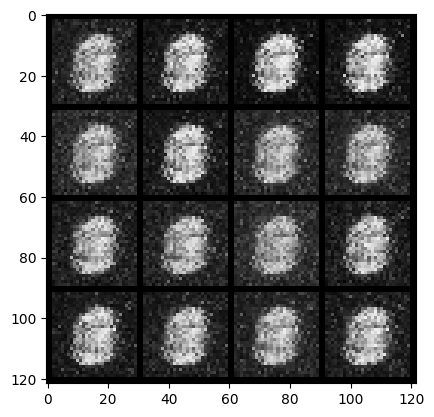

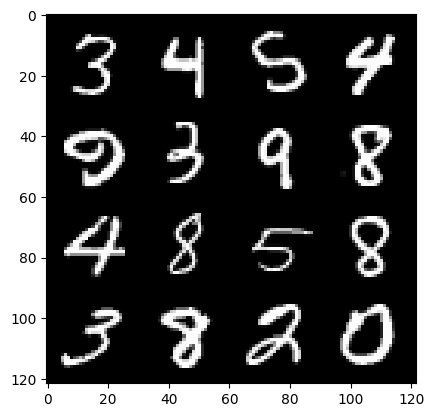

0: step 300 / Gen loss: 1.9786779761314386 / disc_loss: 0.3465215745568275


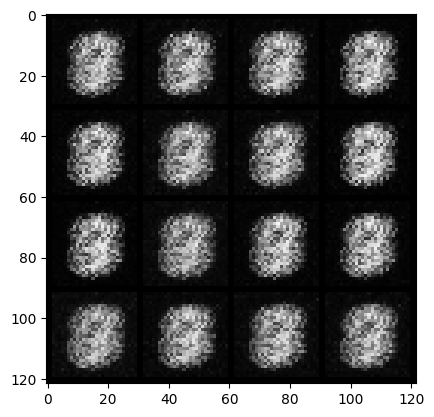

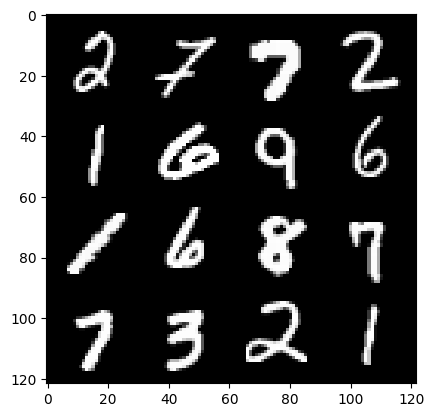

0: step 600 / Gen loss: 3.476604370276133 / disc_loss: 0.11565886060396831


  0%|          | 0/469 [00:00<?, ?it/s]

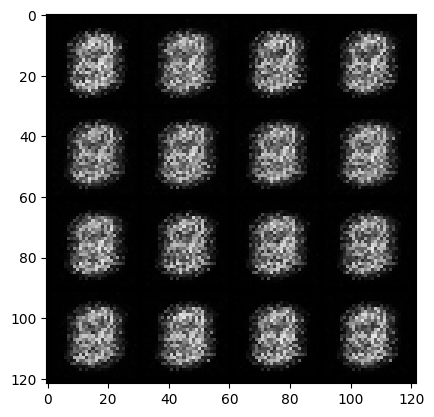

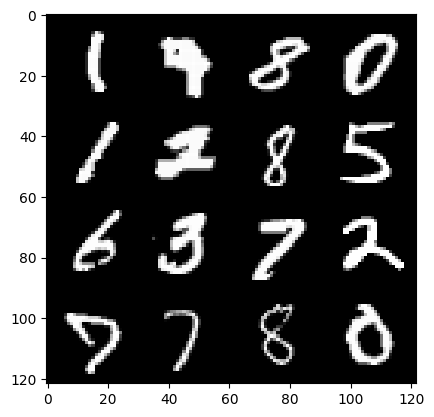

1: step 900 / Gen loss: 3.5763482975959793 / disc_loss: 0.05004871322462961


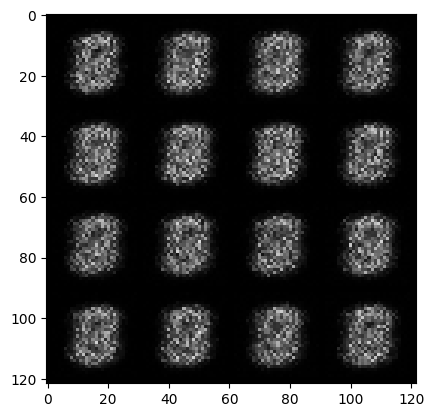

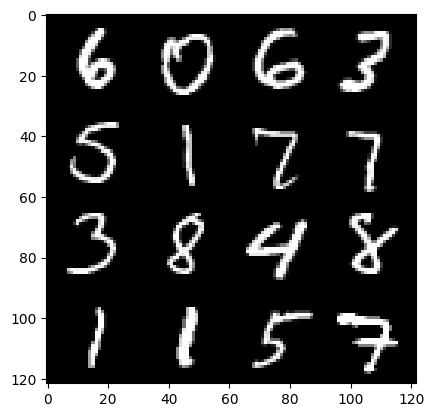

1: step 1200 / Gen loss: 3.692818524042767 / disc_loss: 0.03194922734051946


  0%|          | 0/469 [00:00<?, ?it/s]

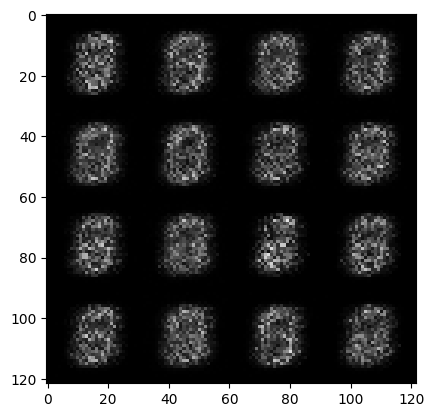

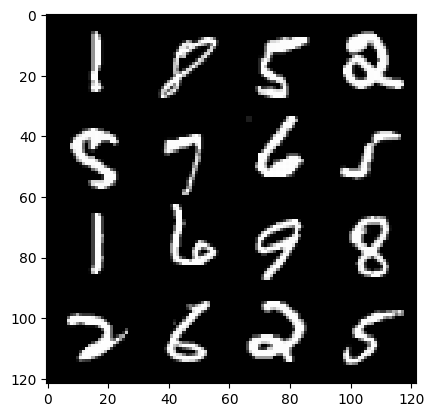

2: step 1500 / Gen loss: 3.387812453905739 / disc_loss: 0.04359974924474953


  0%|          | 0/469 [00:00<?, ?it/s]

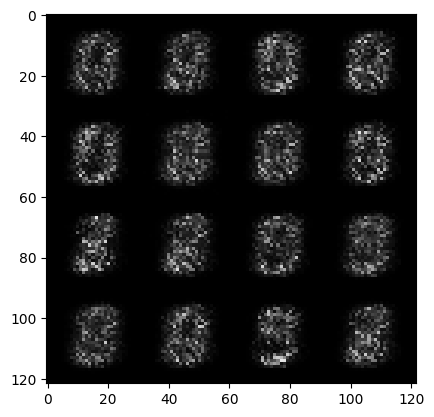

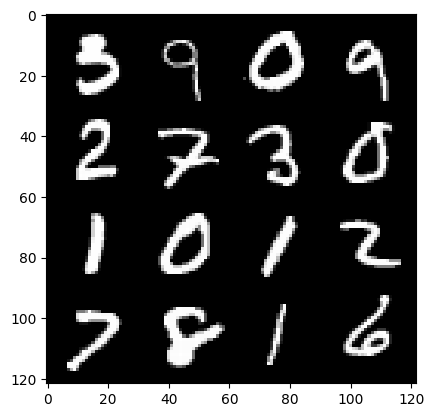

3: step 1800 / Gen loss: 3.114369397958121 / disc_loss: 0.06324011518309515


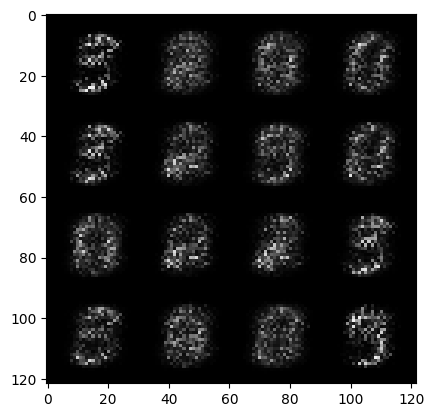

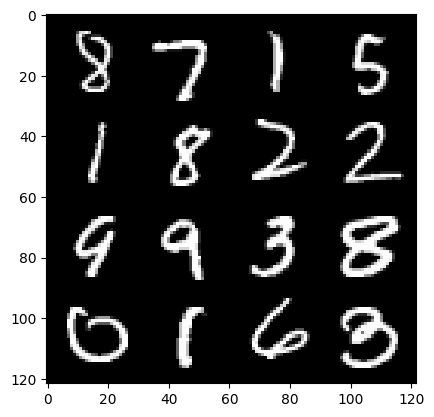

3: step 2100 / Gen loss: 3.4208890382448827 / disc_loss: 0.055750156032542374


  0%|          | 0/469 [00:00<?, ?it/s]

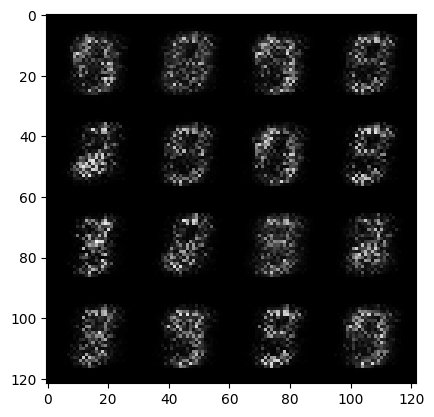

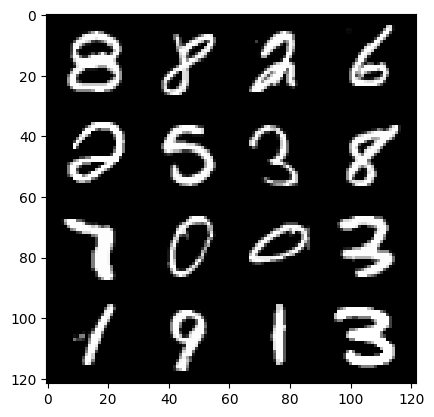

4: step 2400 / Gen loss: 3.4926544109980244 / disc_loss: 0.052394491750746945


  0%|          | 0/469 [00:00<?, ?it/s]

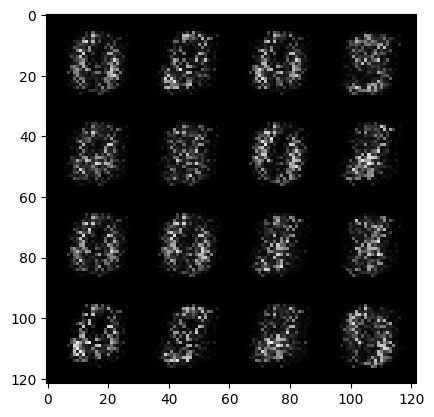

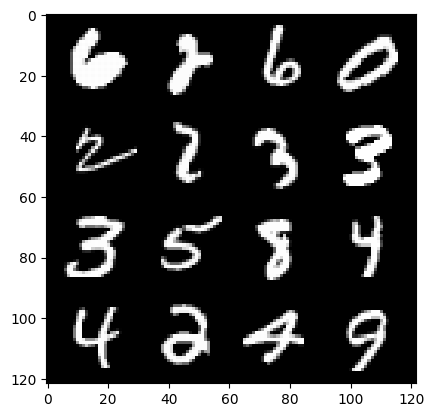

5: step 2700 / Gen loss: 4.024640905062357 / disc_loss: 0.03797472475717464


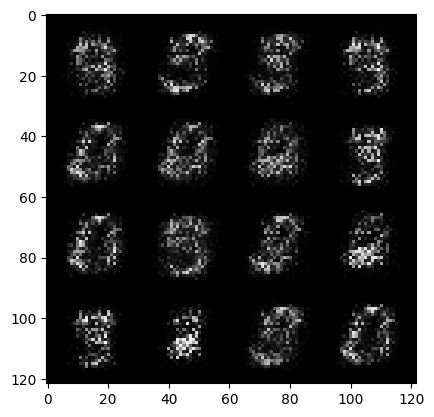

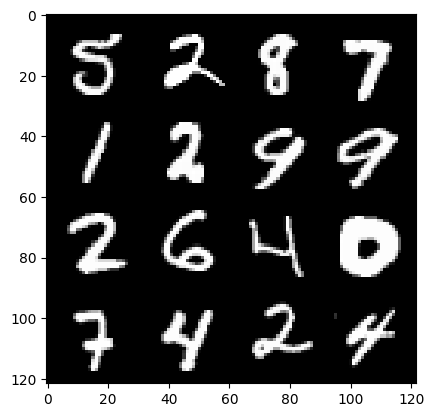

5: step 3000 / Gen loss: 4.715587436358132 / disc_loss: 0.029205245586733042


  0%|          | 0/469 [00:00<?, ?it/s]

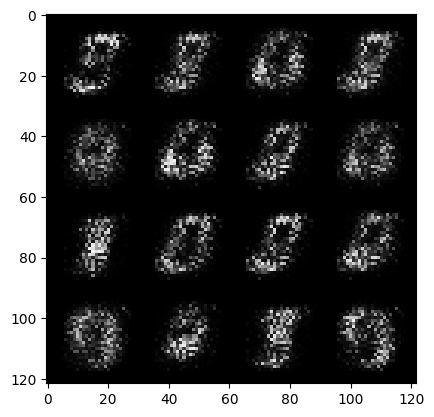

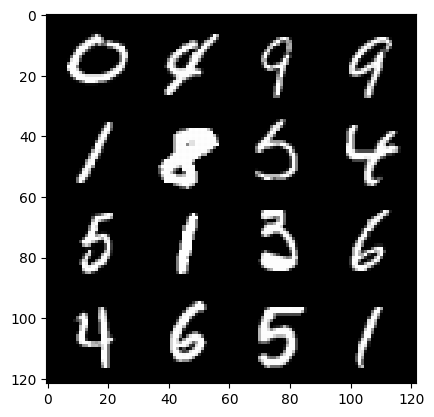

6: step 3300 / Gen loss: 4.930899976094563 / disc_loss: 0.02895474788732827


  0%|          | 0/469 [00:00<?, ?it/s]

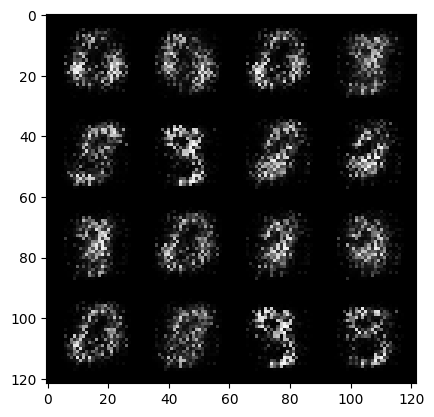

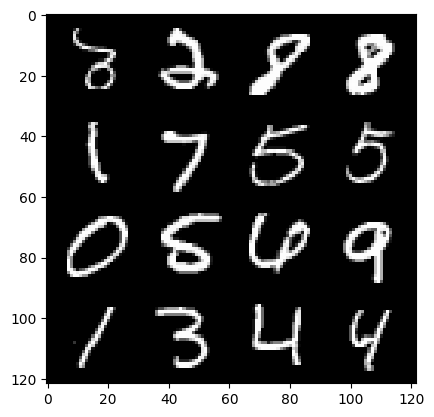

7: step 3600 / Gen loss: 4.808486207326249 / disc_loss: 0.026292163307468076


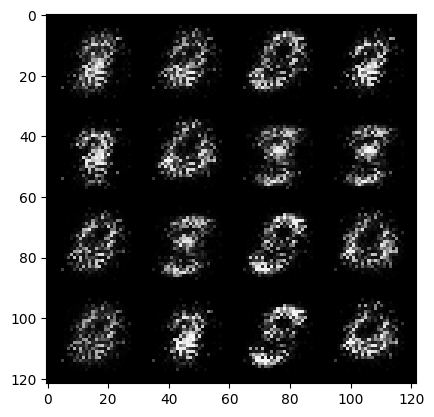

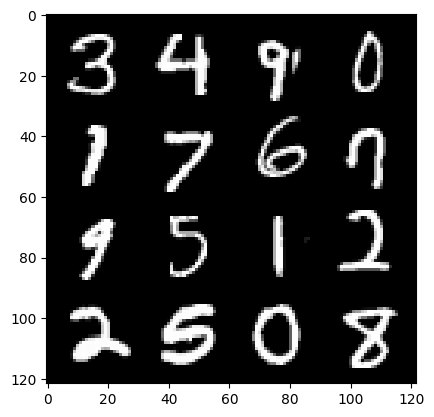

7: step 3900 / Gen loss: 5.418172396024069 / disc_loss: 0.02231883749676248


  0%|          | 0/469 [00:00<?, ?it/s]

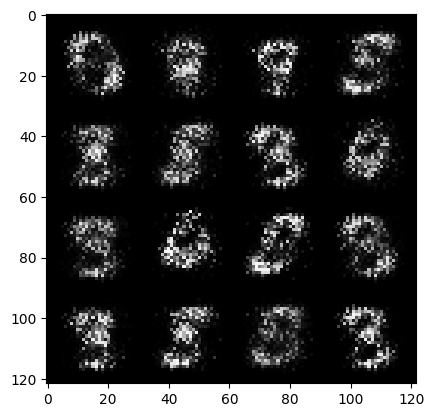

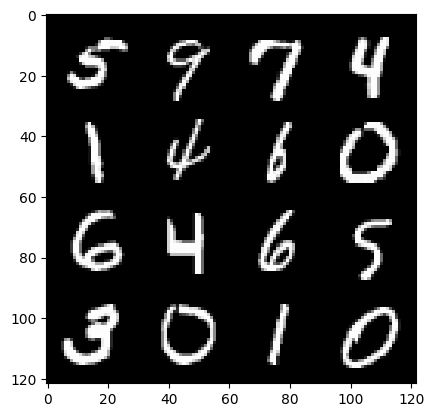

8: step 4200 / Gen loss: 5.762163785298666 / disc_loss: 0.018485582104573645


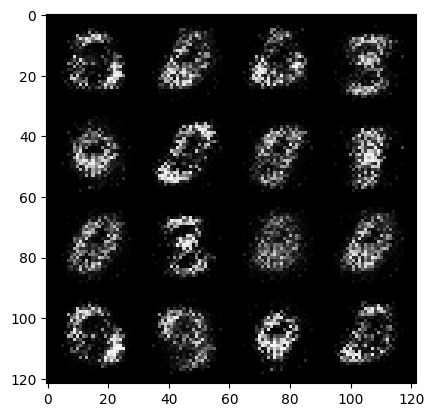

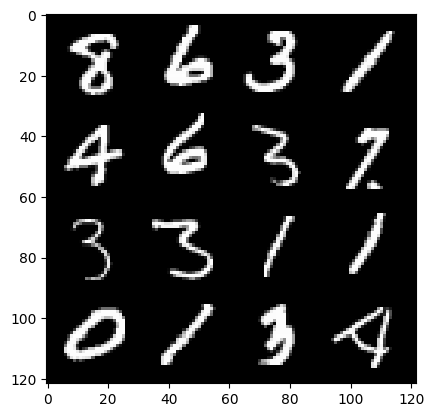

8: step 4500 / Gen loss: 5.867844808896384 / disc_loss: 0.01965713625152905


  0%|          | 0/469 [00:00<?, ?it/s]

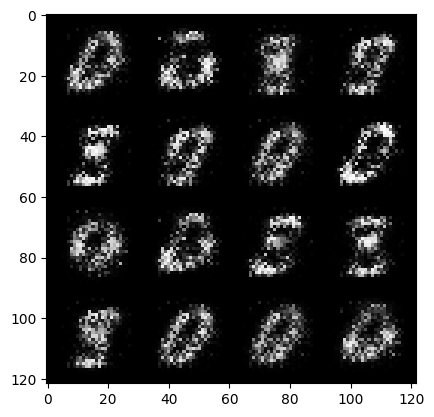

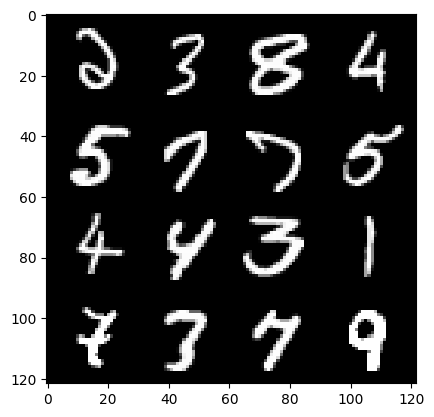

9: step 4800 / Gen loss: 6.033498997688295 / disc_loss: 0.02037700668442994


  0%|          | 0/469 [00:00<?, ?it/s]

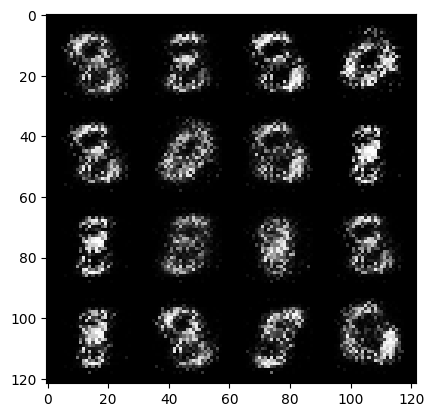

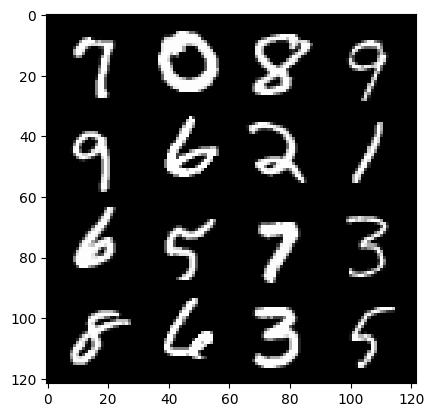

10: step 5100 / Gen loss: 5.888043258984883 / disc_loss: 0.0170454322375978


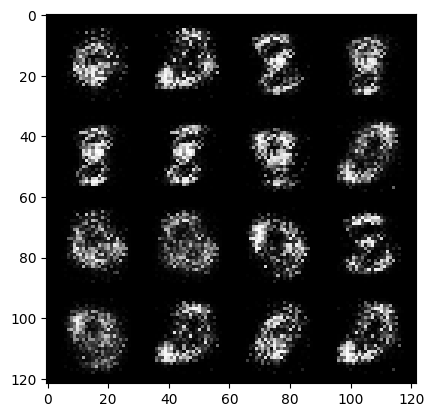

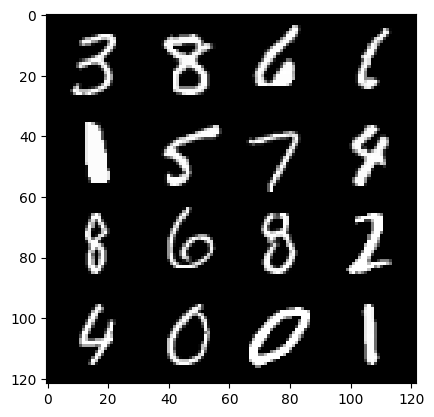

10: step 5400 / Gen loss: 5.92136147975922 / disc_loss: 0.015492489342577756


  0%|          | 0/469 [00:00<?, ?it/s]

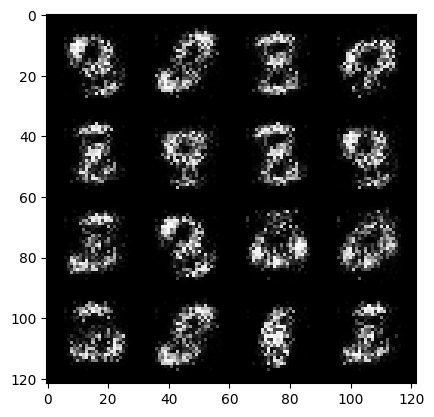

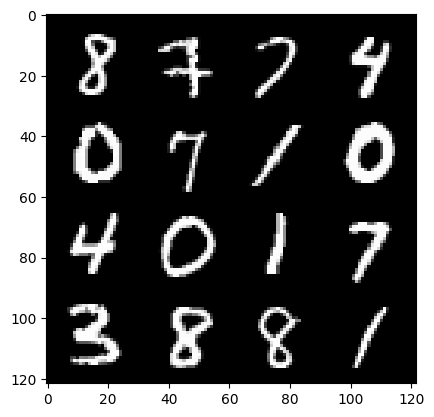

11: step 5700 / Gen loss: 6.21328948020935 / disc_loss: 0.013406117237173021


  0%|          | 0/469 [00:00<?, ?it/s]

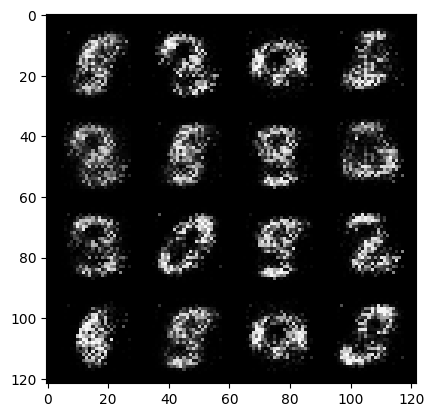

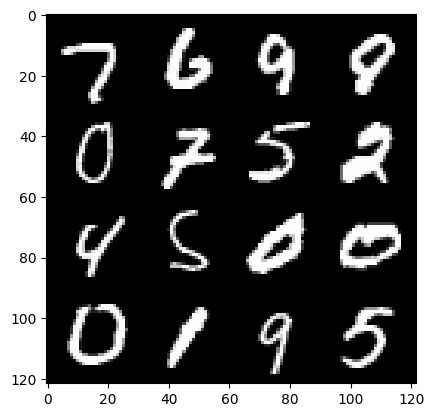

12: step 6000 / Gen loss: 6.440042945543924 / disc_loss: 0.012559034877146283


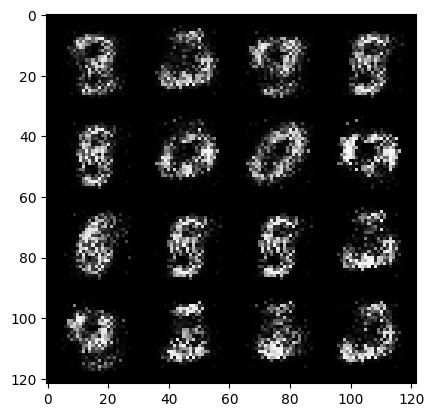

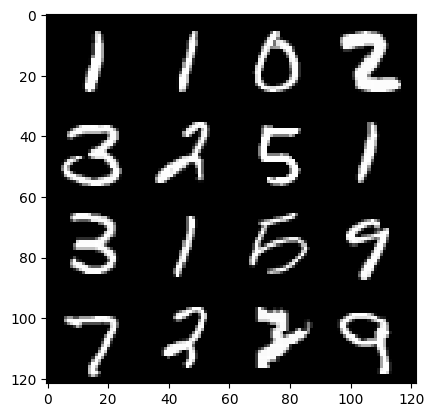

12: step 6300 / Gen loss: 6.421221698125201 / disc_loss: 0.01230521741478394


  0%|          | 0/469 [00:00<?, ?it/s]

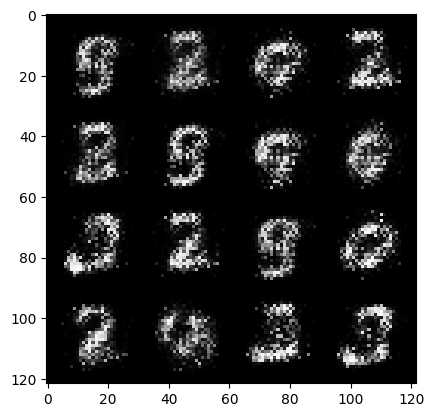

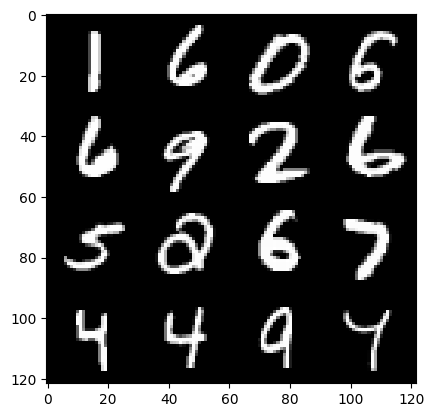

13: step 6600 / Gen loss: 6.566731971104935 / disc_loss: 0.011846494821365922


  0%|          | 0/469 [00:00<?, ?it/s]

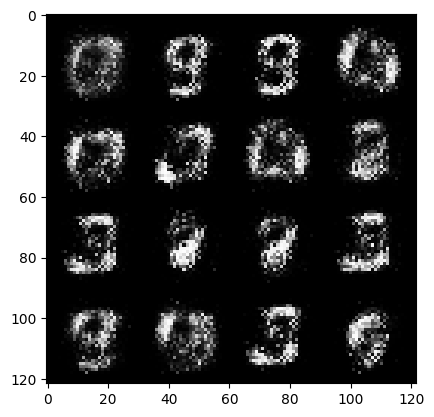

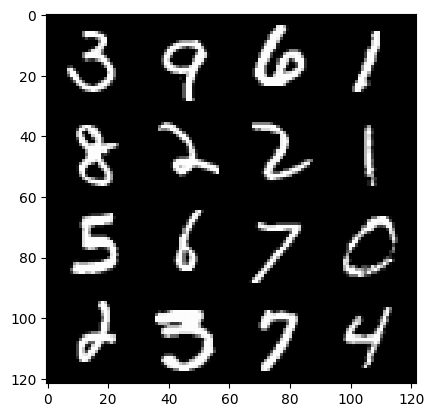

14: step 6900 / Gen loss: 6.736054684321083 / disc_loss: 0.013610099976261449


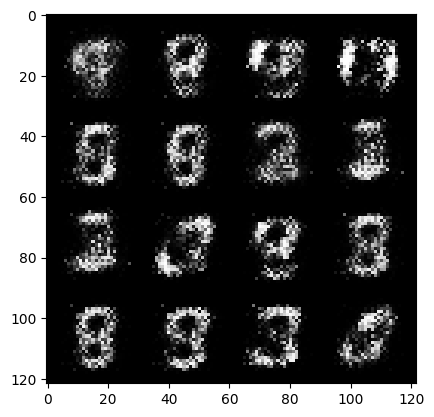

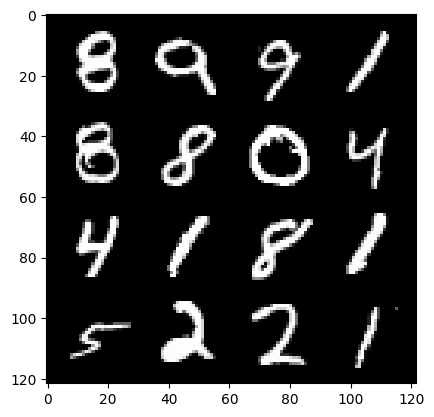

14: step 7200 / Gen loss: 6.843911132812504 / disc_loss: 0.014880021256394682


  0%|          | 0/469 [00:00<?, ?it/s]

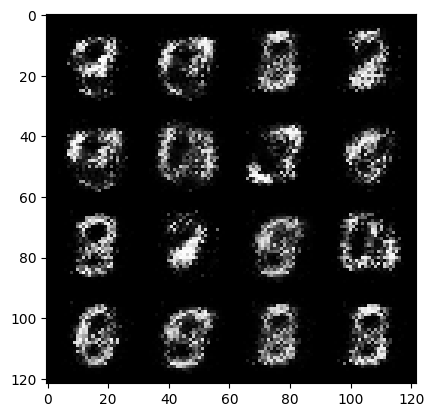

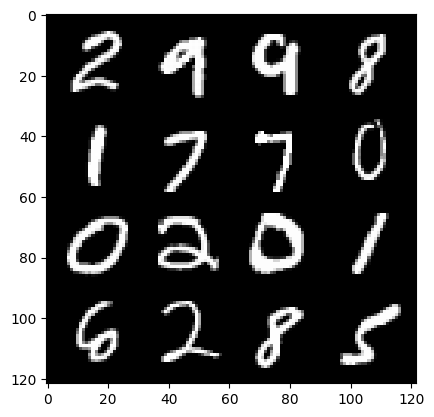

15: step 7500 / Gen loss: 6.728940865198766 / disc_loss: 0.01470093408444276


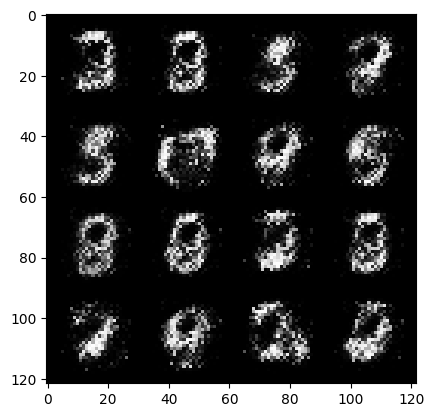

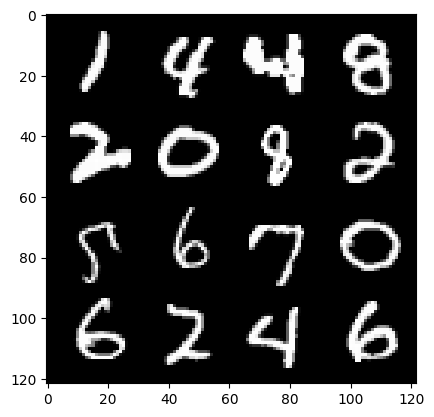

15: step 7800 / Gen loss: 6.539608233769734 / disc_loss: 0.014597027337489034


  0%|          | 0/469 [00:00<?, ?it/s]

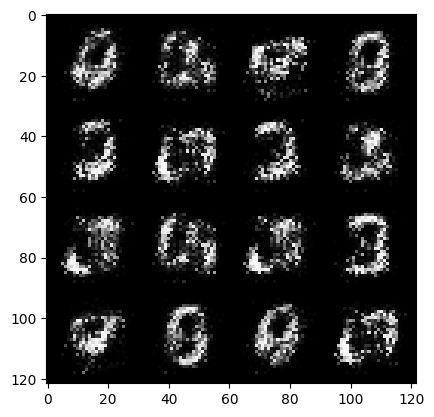

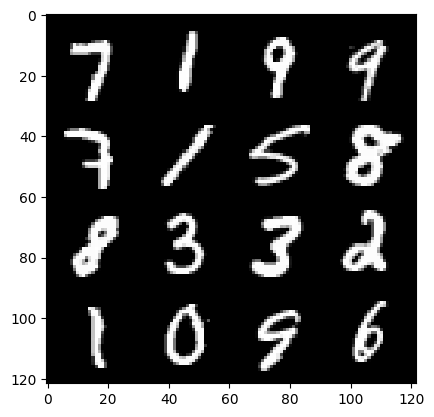

16: step 8100 / Gen loss: 6.762441387176512 / disc_loss: 0.012616536702650291


  0%|          | 0/469 [00:00<?, ?it/s]

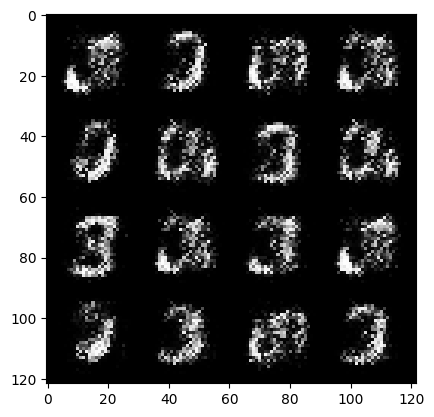

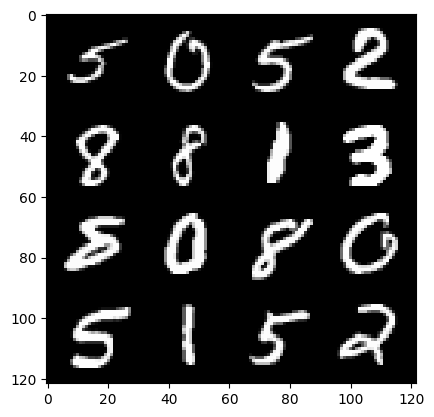

17: step 8400 / Gen loss: 6.619059278170266 / disc_loss: 0.013296957702841611


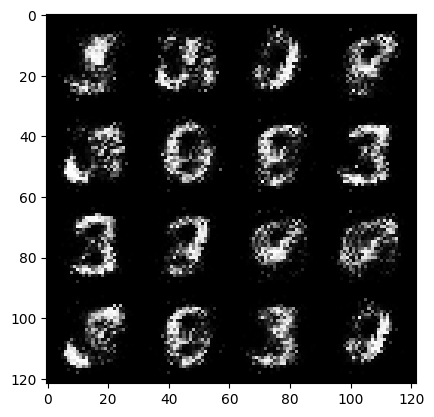

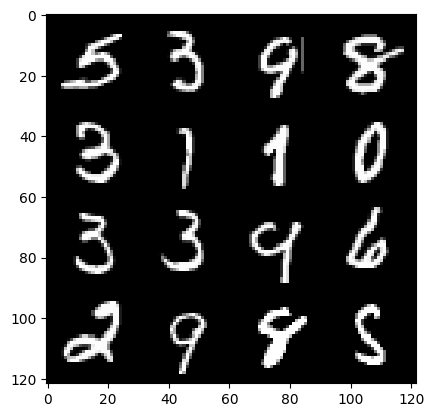

17: step 8700 / Gen loss: 6.320302052497863 / disc_loss: 0.014002755482991526


  0%|          | 0/469 [00:00<?, ?it/s]

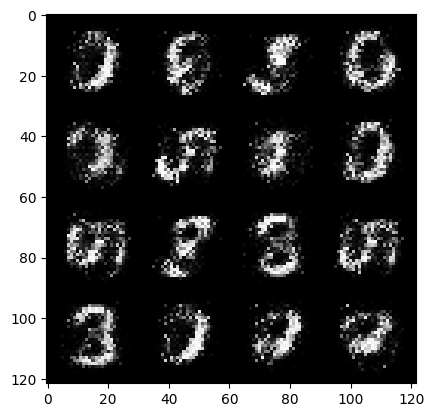

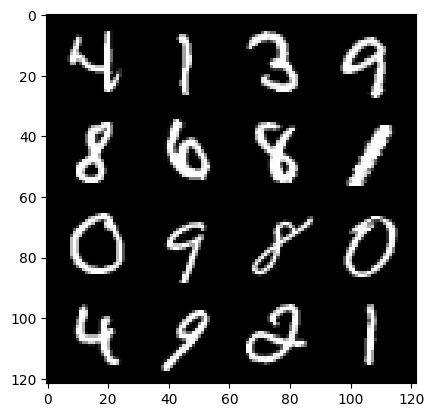

18: step 9000 / Gen loss: 6.357837211290992 / disc_loss: 0.012532966695725917


  0%|          | 0/469 [00:00<?, ?it/s]

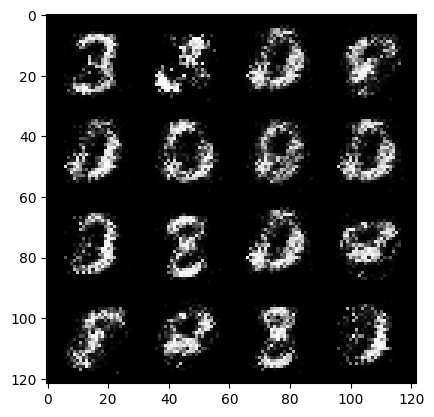

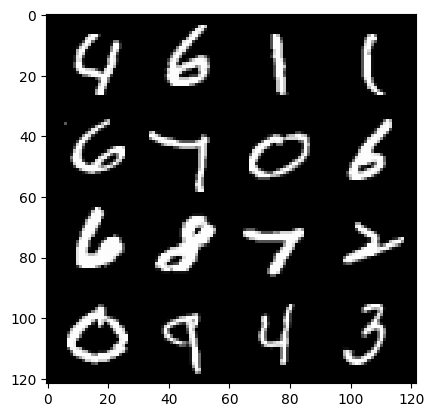

19: step 9300 / Gen loss: 6.477087322870893 / disc_loss: 0.012640131458174437


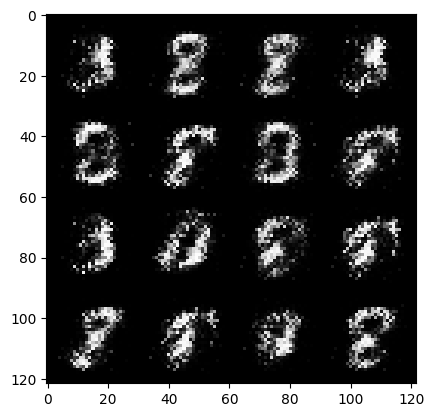

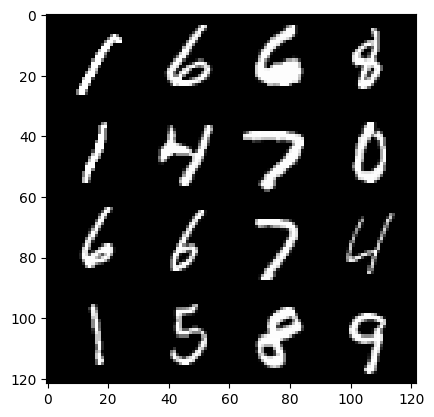

19: step 9600 / Gen loss: 6.608577014605202 / disc_loss: 0.012918192352323481


  0%|          | 0/469 [00:00<?, ?it/s]

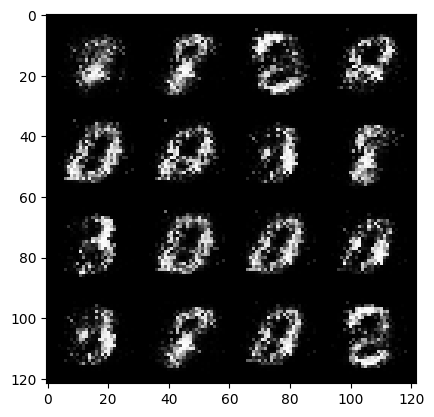

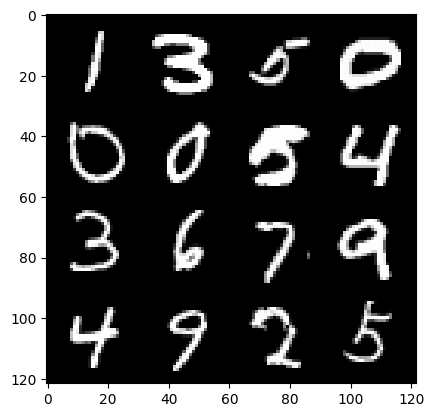

20: step 9900 / Gen loss: 6.625325279235837 / disc_loss: 0.011303398421344655


  0%|          | 0/469 [00:00<?, ?it/s]

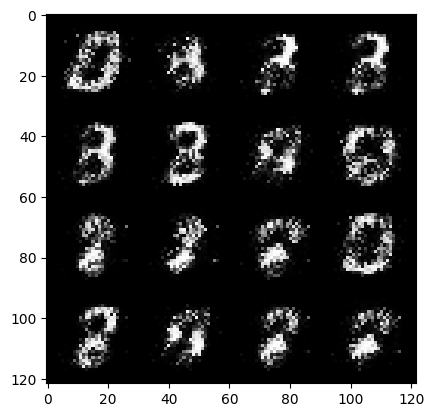

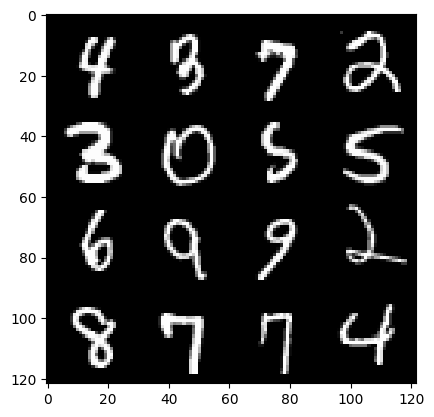

21: step 10200 / Gen loss: 6.500727349917094 / disc_loss: 0.012830329170295342


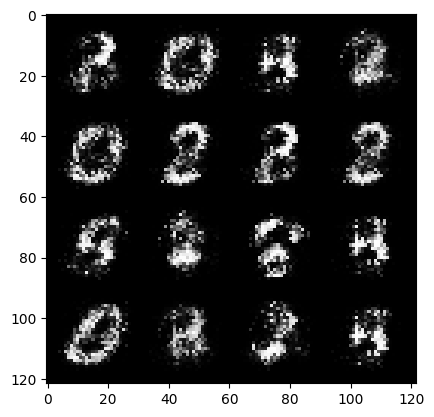

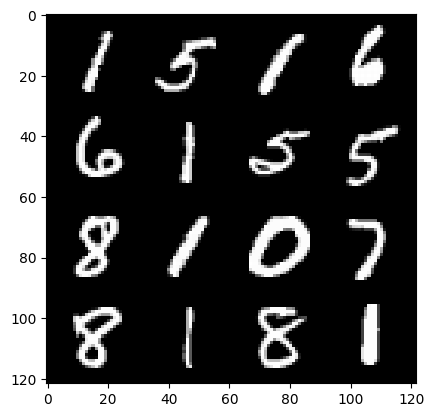

21: step 10500 / Gen loss: 6.638618028958639 / disc_loss: 0.014328771724831317


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
### 60,000 / 128 = 468.75 => 469 steps for each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) #128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    cur_step += 1